## 🚀 Glider Data Cleaning
This section handles the merging, formatting, and preparation of the glider dataset.  
Includes: depth categorization, zone labeling, low oxygen flag, and daily sampling 

The final Data Frame is called (Glider_sampled_df)

In [1]:
import pandas as pd
import glob

#Find all the glider csv files
glider_csv_files = glob.glob("data/Glider data/*.csv")

# Read and merge
df_list = [pd.read_csv(file) for file in glider_csv_files]
Glider_df = pd.concat(df_list, ignore_index=True)

# Optional: save to CSV
# Glider_df.to_csv("Glider_data.csv", index=False)


In [2]:
#Convert Timestamp to Date
Glider_df['time'] = pd.to_datetime(Glider_df['time'])
Glider_df['date'] = Glider_df['time'].dt.strftime('%Y/%m/%d')

In [3]:
#Find the min and max depth
Glider_df['depth'].describe()

count    9.549632e+06
mean     1.224928e+02
std      1.016018e+02
min     -1.784959e-01
25%      3.603288e+01
50%      8.665289e+01
75%      2.025048e+02
max      3.574836e+02
Name: depth, dtype: float64

In [4]:
#Classify all entries by depth (Upper, Mid, Deep)
def classify_depth(depth):
    if depth <= 50:
        return 'Upper'
    elif depth <= 200:
        return 'Mid'
    else:
        return 'Deep'

#Add the depth_category column
Glider_df['depth_category'] = Glider_df['depth'].apply(classify_depth)

# Confirm the new column was added correctly
# Glider_df[['depth', 'depth_category']].head()

In [5]:
#Find the range for both LATITUDE & LONGITUDE
lat_min = Glider_df['latitude'].min()
lat_max = Glider_df['latitude'].max()
lon_min = Glider_df['longitude'].min()
lon_max = Glider_df['longitude'].max()

print(f"Latitude range: {lat_min:.4f}° to {lat_max:.4f}°")
print(f"Longitude range: {lon_min:.4f}° to {lon_max:.4f}°")
print("\nThis means the glider data covers ~250 km north–south and ~400 km east–west.")
print("To match the original case study methodology, we divided the region into ~0.5° grid zones")
print("(approximately ~55 km in latitude × ~40–45 km in longitude at this location).")

Latitude range: 47.0294° to 49.2671°
Longitude range: -64.4084° to -59.6130°

This means the glider data covers ~250 km north–south and ~400 km east–west.
To match the original case study methodology, we divided the region into ~0.5° grid zones
(approximately ~55 km in latitude × ~40–45 km in longitude at this location).


In [6]:
#Add the zone column to the Data Frame
Glider_df['zone'] = (
    (Glider_df['latitude'] // 0.5).astype(int).astype(str) + "_" +
    (Glider_df['longitude'] // 0.5).astype(int).astype(str)
)

# Count total number of Zones (There are 26 in total)
# Glider_df['zone'].nunique()

# #Display the actual zones
Glider_df['zone'].unique()

array(['94_-128', '94_-127', '95_-127', '95_-128', '95_-129', '96_-128',
       '96_-127', '96_-123', '96_-124', '97_-124', '97_-125', '97_-126',
       '96_-125', '97_-127', '97_-128', '97_-129', '98_-129', '98_-128',
       '98_-127', '94_-121', '95_-121', '95_-122', '96_-122', '94_-129',
       '94_-122', '95_-120'], dtype=object)

In [7]:
# Sort zones by numeric latitude and longitude (not alphabetically)
zone_tuples = [tuple(map(int, z.split('_'))) for z in Glider_df['zone'].unique()]
sorted_zones = sorted(zone_tuples)
sorted_zone_strings = [f"{lat}_{lon}" for lat, lon in sorted_zones]

# Create mapping: zone strings (e.g. "94_-128") → zone labels ("zone1", "zone2", ...)
# Zones are ordered numerically from southwest to northeast
zone_mapping = {zone: f"zone{i+1}" for i, zone in enumerate(sorted_zone_strings)}

In [8]:
#Apply the mapping to create a new readable zone label
Glider_df['zone_label'] = Glider_df['zone'].map(zone_mapping)

In [9]:
#Check columns were added correctly
print(Glider_df.columns)

#Preview a few of the rows
Glider_df[['latitude', 'longitude', 'zone', 'zone_label']].head()

Index(['time', 'latitude', 'longitude', 'depth', 'sea_water_temperature',
       'sea_water_practical_salinity', 'sea_water_density',
       'micromoles_of_oxygen_per_unit_mass_in_sea_water', 'date',
       'depth_category', 'zone', 'zone_label'],
      dtype='object')


,latitude,longitude,zone,zone_label
0,47.417050,-63.907473,94_-128,zone2
1,47.417050,-63.907469,94_-128,zone2
2,47.417049,-63.907464,94_-128,zone2
3,47.417049,-63.907460,94_-128,zone2
4,47.417049,-63.907456,94_-128,zone2


In [10]:
# Using 60 μmol/kg as the threshold to identify low oxygen levels,
# as it's a common early indicator of hypoxic conditions in marine environments.
threshold = 60  # μmol/kg
Glider_df['low_oxygen'] = (Glider_df['micromoles_of_oxygen_per_unit_mass_in_sea_water'] < threshold).astype(int)

#Count how many points fall in each category
Glider_df['low_oxygen'].value_counts()

low_oxygen
0    9486118
1      63514
Name: count, dtype: int64

In [11]:
import warnings

#Suppress deprecation warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)

    #Sample 30 rows per day from Glider_df (Central Limit Theorem)
    Glider_sampled_df = (
        Glider_df.groupby('date', group_keys=False)
        .apply(lambda group: group.sample(n=min(30, len(group)), random_state=42))
        .reset_index(drop=True)
    )

In [12]:
#Check how many rows were sampled
Glider_sampled_df['date'].value_counts().sort_index()

date
2018/07/20    30
2018/07/21    30
2018/07/22    30
2018/07/23    30
2018/07/24    30
              ..
2023/11/03    30
2023/11/04    30
2023/11/05    30
2023/11/06    30
2023/11/07    30
Name: count, Length: 616, dtype: int64

In [13]:
#Check the number of unique dates in the sample data
print(f"Unique dates in sample: {Glider_sampled_df['date'].nunique()}")

#Check the number of dates in the original data
print(f"Unique dates in original: {Glider_df['date'].nunique()}")

print("Since the values match, we can conclude that all dates in the original dataset were included in the sample.")

Unique dates in sample: 616
Unique dates in original: 616
Since the values match, we can conclude that all dates in the original dataset were included in the sample.


In [14]:
#Preview a few sampled rows
Glider_sampled_df[['time', 'date', 'depth', 'zone_label', 'micromoles_of_oxygen_per_unit_mass_in_sea_water', 'low_oxygen']].head(10)

,time,date,depth,zone_label,micromoles_of_oxygen_per_unit_mass_in_sea_water,low_oxygen
0,2018-07-20 08:23:03,2018/07/20,15.359852,zone6,257.602202,0
1,2018-07-20 14:53:19,2018/07/20,17.293387,zone6,260.670374,0
2,2018-07-20 01:12:33,2018/07/20,65.130033,zone6,261.678744,0
3,2018-07-20 12:04:11,2018/07/20,40.058139,zone6,279.215534,0
4,2018-07-20 08:59:40,2018/07/20,20.337425,zone6,261.280794,0
5,2018-07-20 18:54:07,2018/07/20,18.636942,zone6,257.589293,0
6,2018-07-20 09:33:14,2018/07/20,59.529108,zone6,252.903920,0
7,2018-07-20 10:06:52,2018/07/20,60.282520,zone6,290.530779,0
8,2018-07-20 07:44:11,2018/07/20,19.945773,zone6,259.127375,0
9,2018-07-20 08:17:29,2018/07/20,49.238673,zone6,271.414118,0


## ✅ End of Glider Data Cleaning

## 💧 Bottle Data Cleaning
This section filters out low-quality or missing data from the bottle dataset,  
adds timestamps and date formatting for alignment with glider data.

In [15]:
#Find the bottle data
bottle_df = pd.read_excel("data/Bottle data/Bottle Oxygen Data.xlsx")

# Filter out invalid oxygen values and keep only high-quality measurements
bottle_df = bottle_df[
    (bottle_df['best_Oxygen'] != -999) & 
    (bottle_df['best_Oxygen_FLAG'] == 2)
].copy()

# Create a full timestamp from UTC components
bottle_df['timestamp'] = pd.to_datetime({
    'year': bottle_df['Year_UTC'],
    'month': bottle_df['Month_UTC'],
    'day': bottle_df['Day_UTC'],
    'hour': bottle_df['Hour_UTC'],
    'minute': bottle_df['Minute_UTC']
})

# Extract a date column for easier grouping and comparison
bottle_df['date'] = bottle_df['timestamp'].dt.strftime('%Y/%m/%d')

# Keep only the relevant columns for comparison
bottle_df = bottle_df[['Latitude', 'Longitude', 'timestamp', 'date', 'best_Oxygen']]

In [16]:
#Check unnessesary columns were removed correctly
print(bottle_df.columns)

#Check the number of rows is less than the original 863
print(f"Number of cleaned rows: {len(bottle_df)}")

#Check if there are any remaning missing values
print(bottle_df.isna().sum())

#Preview the first few rows
bottle_df.head()

Index(['Latitude', 'Longitude', 'timestamp', 'date', 'best_Oxygen'], dtype='object')
Number of cleaned rows: 503
Latitude       0
Longitude      0
timestamp      0
date           0
best_Oxygen    0
dtype: int64


,Latitude,Longitude,timestamp,date,best_Oxygen
0,49.101389,-67.2775,2021-10-22 21:07:00,2021/10/22,28.908497
1,49.101389,-67.2775,2021-10-22 21:07:00,2021/10/22,57.633972
2,49.101389,-67.2775,2021-10-22 21:07:00,2021/10/22,90.840147
3,49.101389,-67.2775,2021-10-22 21:07:00,2021/10/22,244.645609
4,49.101389,-67.2775,2021-10-22 21:07:00,2021/10/22,265.664677


In [17]:
#Adding the low_oxygen column to macth glider format with the same threshold as before (threshold = 60  # μmol/kg)
bottle_df['low_oxygen'] = (bottle_df['best_Oxygen'] < threshold).astype(int)

#Checking top values to confirm tag was added correctly
bottle_df[['best_Oxygen', 'low_oxygen']].head(10)

,best_Oxygen,low_oxygen
0,28.908497,1
1,57.633972,1
2,90.840147,0
3,244.645609,0
4,265.664677,0
5,269.623002,0
6,37.712004,1
7,34.026815,1
8,277.146930,0
9,50.558983,1


In [18]:
# To keep consistency with the glider data, we assign zones using the same 0.5° grid system
bottle_df['zone'] = (
    (bottle_df['Latitude'] // 0.5).astype(int).astype(str) + "_" +
    (bottle_df['Longitude'] // 0.5).astype(int).astype(str)
)

# Sort zones numerically by latitude and longitude (not alphabetically)
zone_tuples = [tuple(map(int, z.split('_'))) for z in bottle_df['zone'].unique()]
sorted_zones = sorted(zone_tuples)
sorted_zone_strings = [f"{lat}_{lon}" for lat, lon in sorted_zones]

# Create mapping: zone strings (e.g., "94_-128") → zone labels ("zone1", "zone2", ...)
# Zones are labeled from southwest to northeast
zone_mapping = {zone: f"zone{i+1}" for i, zone in enumerate(sorted_zone_strings)}

# Apply the mapping to create a new readable zone label column
bottle_df['zone_label'] = bottle_df['zone'].map(zone_mapping)

In [19]:
#Check columns were added correctly
print(bottle_df.columns)

#Preview a few of the rows
bottle_df.head(10)

Index(['Latitude', 'Longitude', 'timestamp', 'date', 'best_Oxygen',
       'low_oxygen', 'zone', 'zone_label'],
      dtype='object')


,Latitude,Longitude,timestamp,date,best_Oxygen,low_oxygen,zone,zone_label
0,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,28.908497,1,98_-135,zone18
1,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,57.633972,1,98_-135,zone18
2,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,90.840147,0,98_-135,zone18
3,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,244.645609,0,98_-135,zone18
4,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,265.664677,0,98_-135,zone18
5,49.101389,-67.277500,2021-10-22 21:07:00,2021/10/22,269.623002,0,98_-135,zone18
6,49.428889,-66.331944,2021-10-23 02:10:00,2021/10/23,37.712004,1,98_-133,zone20
7,49.428889,-66.331944,2021-10-23 02:10:00,2021/10/23,34.026815,1,98_-133,zone20
8,49.428889,-66.331944,2021-10-23 02:10:00,2021/10/23,277.146930,0,98_-133,zone20
9,49.498056,-65.225278,2021-10-23 06:53:00,2021/10/23,50.558983,1,98_-131,zone21


## ✅ End of Bottle Data Cleaning

In [20]:
Glider_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9549632 entries, 0 to 9549631
Data columns (total 13 columns):
 #   Column                                           Dtype         
---  ------                                           -----         
 0   time                                             datetime64[ns]
 1   latitude                                         float64       
 2   longitude                                        float64       
 3   depth                                            float64       
 4   sea_water_temperature                            float64       
 5   sea_water_practical_salinity                     float64       
 6   sea_water_density                                float64       
 7   micromoles_of_oxygen_per_unit_mass_in_sea_water  float64       
 8   date                                             object        
 9   depth_category                                   object        
 10  zone                                             objec

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
# # Create a figure with 4 subplots (2 rows, 2 columns)
# Glider_sampled_df.rename(columns = {'micromoles_of_oxygen_per_unit_mass_in_sea_water': 'oxygen_concentration'},inplace=True)
# fig, axes = plt.subplots(2, 2, figsize=(18, 16))

# #First plot (top left)
# sns.boxplot(
#     x=pd.cut(Glider_sampled_df['sea_water_temperature'], bins=6),
#     y='oxygen_concentration',
#     data=Glider_sampled_df,
#     ax=axes[0, 0]
# )
# axes[0, 0].set_title('Oxygen Concentration vs water temperature')
# axes[0, 0].set_xlabel('Sea Water Temperature in celsius')
# axes[0, 0].set_ylabel('Oxygen Concentration')

# #Second plot (top right)
# sns.boxplot(
#     x=pd.cut(Glider_sampled_df['sea_water_practical_salinity'], bins=6),
#     y='oxygen_concentration',
#     data=Glider_sampled_df,
#     ax=axes[0, 1]
# )
# axes[0, 1].set_title('Oxygen Concentration vs water salinity')
# axes[0, 1].set_xlabel('concentration of salt in water')
# axes[0, 1].set_ylabel('Oxygen Concentration')

# #Third plot (bottom left)
# sns.boxplot(
#     x=pd.cut(Glider_sampled_df['sea_water_density'], bins=5),
#     y='oxygen_concentration',
#     data=Glider_sampled_df,
#     ax=axes[1, 0]
# )
# axes[1, 0].set_title('Oxygen Concentration vs water density')
# axes[1, 0].set_xlabel('Sea Water Density')
# axes[1, 0].set_ylabel('Oxygen Concentration')

# #Fourth plot (bottom right)
# sns.boxplot(
#     x='depth_category',
#     y='oxygen_concentration',
#     data=Glider_sampled_df,
#     ax=axes[1, 1]
# )
# axes[1, 1].set_title('Oxygen Concentration vs depth category')
# axes[1, 1].set_xlabel('Depth Category')
# axes[1, 1].set_ylabel('Oxygen Concentration')

# plt.tight_layout()
# plt.show()

In [37]:
import numpy as np
# plt.figure(figsize=(24,20))
# varstolook = ['sea_water_density', 'sea_water_temperature', 'sea_water_practical_salinity'] #Sea water denisty and salinity seem to be very correlated
# for i,feature in enumerate(varstolook):
#     plt.subplot(2,2,i+1) 
#     colvalues = Glider_sampled_df[feature]
#     plt.scatter(colvalues.values, Glider_sampled_df.oxygen_concentration.values, alpha=0.20, edgecolor=None, color='red') #oxy vs sea_water_temperature is odd (5 degrees)
#     plt.xlabel(feature)
#     plt.ylabel('oxy')
#     plt.title("oxy vs. " + feature, fontsize=20, verticalalignment='bottom');

In [38]:
import statsmodels.api as sm
# fig = sm.qqplot(Glider_sampled_df['oxygen_concentration'], line='r') #oxygen concentration shows heavy non-normality
# plt.show()

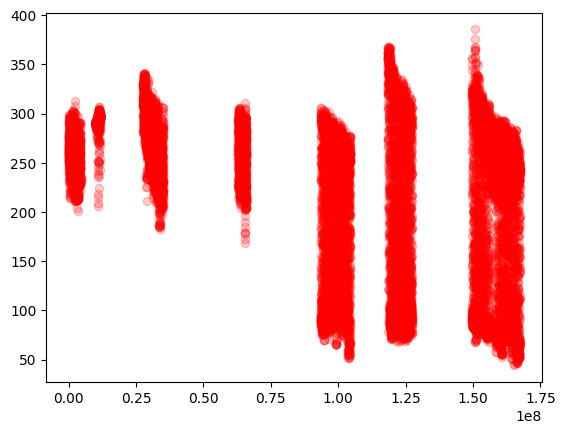

In [40]:
Glider_sampled_df = Glider_sampled_df.sort_values(by='time').reset_index(drop=True)
Glider_sampled_df['time_seconds'] = (Glider_sampled_df['time'] - Glider_sampled_df['time'].iloc[0]) / np.timedelta64(1, 's') #oxygen concentration over time
Glider_sampled_df.rename(columns = {'micromoles_of_oxygen_per_unit_mass_in_sea_water': 'oxygen_concentration'},inplace=True)

plt.scatter(Glider_sampled_df['time_seconds'], Glider_sampled_df['oxygen_concentration'], alpha=0.20, color='red')
plt.show()